# Binned Jeans analysis tutorial

In this example, we will use JeansGNN to perform a binned Jeans analysis to recover
the dark matter density profile of an example dwarf galaxy.

This implementation is based on the following paper:
- [1] Chang & Necib (2020) https://arxiv.org/abs/2009.00613

In [1]:
%load_ext autoreload
%autoreload 2

import bilby
import corner
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import torch_geometric
import yaml

import jeans_gnn as jgnn

%matplotlib inline

/mnt/home/tnguyen/miniconda3/envs/conda-torch/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Read an example galaxy 
As a first step, we read the 2D position and line-of-sight velocity of the stars in the example galaxy. 

Note that unlike the GNN-based inference in `jgnn.gnn`, the Jeans analysis is more computationally intensive, so we can only fit one galaxy at a time.

In [5]:
# Read the example datasets and pick the first galaxy (though any galaxy will work)
dataset_path = 'data/example_data.hdf5'
node_features, graph_features, headers = jgnn.utils.dataset.read_graph_dataset(
    dataset_path, features_list=['pos', 'vel', 'labels'])

# Pick the first galaxy
pos = node_features['pos'][0]
vel = node_features['vel'][0]
truth_parameters = {
    k: v for k, v in zip(headers['labels_order'], graph_features['labels'][0])}

# Print out the truth parameters and the node features of the first 10 stars
print('True parameters:')
for k, v in truth_parameters.items():
    print(f'{k}: {v}')
print("Node features:")
print("- pos: {}".format(node_features['pos'][0][:10]))
print("- vel: {}".format(node_features['vel'][0][:10]))

True parameters:
dm_gamma: 1.795510261604735
dm_log_r_dm: -0.9484176932271604
dm_log_rho_0: 6.900775501260086
stellar_log_r_star: -1.1235643171439753
df_beta_0: -0.1819504098684881
df_log_r_a: -0.909685555630339
Node features:
- pos: [[ 0.13504457  0.05950324]
 [-0.03729184 -0.151646  ]
 [-0.11927976 -0.11157647]
 [-0.03330625  0.06756137]
 [-0.00840738  0.03095477]
 [ 0.07772832 -0.04542598]
 [-0.06865919 -0.04856362]
 [ 0.02304553  0.0593613 ]
 [ 0.00202816  0.00174576]
 [ 0.10052064  0.04847484]]
- vel: [ 0.29824803 -0.04545442  0.21565156 -0.46745416 -0.20959343 -0.14228842
  0.66527882  0.53476856  0.24639451 -0.36439535]


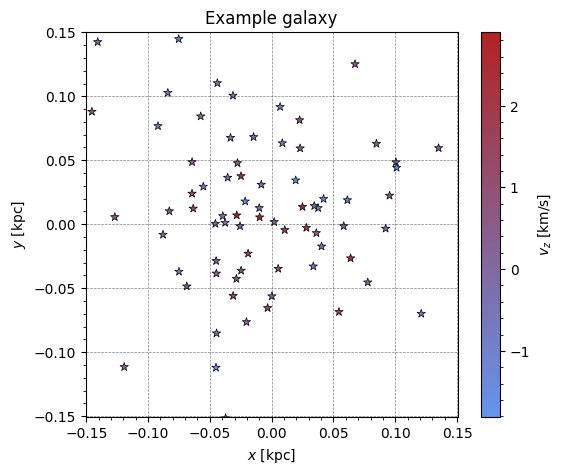

In [17]:
# Plot the example galaxy
fig, ax = plt.subplots(1, 1, figsize=(6, 5))

# some plotting parameters
s = 40
marker = '*'
# create a colormap by adding gradients between colors
color1 = 'cornflowerblue'
color2 = 'firebrick'
cmap = mpl.colors.LinearSegmentedColormap.from_list(
    'mycmap', [color1, color2])
box_size = 2 * 10**truth_parameters['stellar_log_r_star']

# create a log scale for the colorbar
norm = mpl.colors.Normalize(vmin=vel.min(), vmax=vel.max())

# plot the stars
sc = ax.scatter(
    pos[:, 0], pos[:, 1], c=vel, s=s, marker=marker, cmap=cmap,
    norm=norm, edgecolors='k', linewidths=0.5)
ax.set_xlabel(r'$x$ [kpc]')
ax.set_ylabel(r'$y$ [kpc]')
ax.set_title('Example galaxy')
ax.set_xlim(-box_size, box_size)
ax.set_ylim(-box_size, box_size)

# minor ticks and major grid
ax.minorticks_on()
ax.grid(which='major', linestyle='--', alpha=0.5, linewidth='0.5', color='black')

# colorbar
cbar = fig.colorbar(sc, ax=ax)
cbar.set_label(r'$v_z$ [km/s]')
cbar.ax.minorticks_on()

plt.show()

## Example 1: Fit the Plummer profile to the light profile

In this example, we will fit the 2D Plummer profile to the light profile of the galaxy. This is a good first step to check if the JeansGNN is working properly.

The 2D Plummer profile has the following form:
$$
I(R) = \frac{L}{\pi a^2} \left[ 1 + \left(\frac{R}{a}\right)^2 \right]^{-2} 
$$
where $L$ is the total luminosity of the galaxy, $a$ is the Plummer scale length, and $R$ is the 2D radius from the center of the galaxy.

In order to fit the Plummer profile with JeansGNN, we will use `jgnn.jeans.binned_jeans.BinnedLPModel`. We need to specify the following:
- `density`: The light profile of the galaxy, which is a `jgnn.jeans.density_profile.DensityProfile` object. In this example, we will use `jgnn.jeans.density_profile.PlummerProfile` to represent the Plummer profile.
- `radius2d`: The 2D radius of the stars in the galaxy.
- `priors`: A dictionary containing all the prior distributions in `bilby.core.prior` format.


In [22]:
# Define the bilby priors
priors = bilby.core.prior.PriorDict()
priors["L"] = bilby.core.prior.LogUniform(1e-2, 1e5, "L")
priors["r_star"] = bilby.core.prior.LogUniform(1e-3, 1e3, "r_star")

# calculate the projected radii
radius2d = np.linalg.norm(pos, axis=1)

# Define the light profile model
lp_model = jgnn.jeans.binned_jeans.BinnedLPModel(
    jgnn.jeans.density_profiles.Plummer, radius2d, priors)

We will run the fit using `bilby` and `dynesty`

In [24]:
# run sampler
results = lp_model.run_sampler(
    sampler="dynesty", npoints=100, sample='auto', npool=1, dlogz=0.1,
    label="lp", outdir='example_binned_jeans', resume=False
)

# note that we can also read in results using bilby.core.result.read_in_result
# results = bilby.core.result.read_in_result(
#     label="lp", outdir='example_binned_jeans')

19:27 bilby INFO    : Running for label 'lp', output will be saved to 'example_binned_jeans'
19:27 bilby INFO    : Analysis priors:
19:27 bilby INFO    : L=LogUniform(minimum=0.01, maximum=100000.0, name='L', latex_label='L', unit=None, boundary=None)
19:27 bilby INFO    : r_star=LogUniform(minimum=0.001, maximum=1000.0, name='r_star', latex_label='r_star', unit=None, boundary=None)
19:27 bilby INFO    : Analysis likelihood class: <class 'jeans_gnn.jeans.binned_jeans.BinnedLPModel'>
19:27 bilby INFO    : Analysis likelihood noise evidence: nan
19:27 bilby INFO    : Single likelihood evaluation took 1.544e-04 s
19:27 bilby INFO    : Using sampler Dynesty with kwargs {'nlive': 100, 'bound': 'live', 'sample': 'auto', 'periodic': None, 'reflective': None, 'update_interval': 600, 'first_update': None, 'npdim': None, 'rstate': None, 'queue_size': 1, 'pool': None, 'use_pool': None, 'live_points': None, 'logl_args': None, 'logl_kwargs': None, 'ptform_args': None, 'ptform_kwargs': None, 'gradie

1012it [00:00, 1046.16it/s, bound:5 nc:  3 ncall:5.9e+03 eff:17.0% logz=-9.55+/-0.26 dlogz:0.102>0.1]   

19:27 bilby INFO    : Written checkpoint file example_binned_jeans/lp_resume.pickle


1013it [00:03, 286.00it/s, bound:5 nc:  1 ncall:6.1e+03 eff:18.7% logz=-9.45+/-0.25 dlogz:0.001>0.1] 

19:27 bilby INFO    : Rejection sampling nested samples to obtain 259 posterior samples
19:27 bilby INFO    : Sampling time: 0:00:03.538228
19:27 bilby INFO    : Summary of results:
nsamples: 259
ln_noise_evidence:    nan
ln_evidence: -9.455 +/-  0.305
ln_bayes_factor:    nan +/-  0.305



To examine the posteriors, we first compare the 1D marginalized posteriors of the parameters with the truth values. 

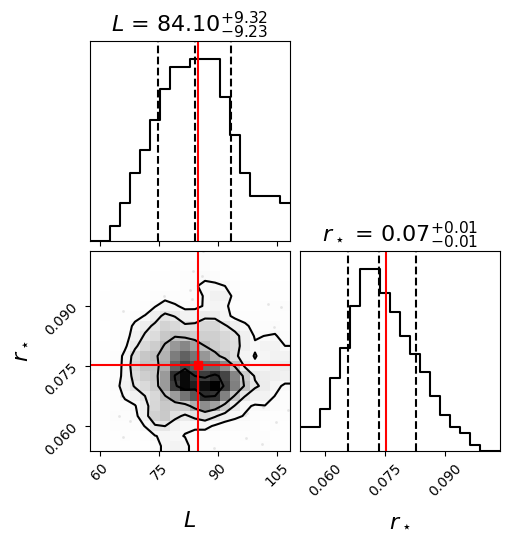

In [33]:
# get posterior samples
samples = results.posterior[['L', 'r_star']].to_numpy()

# set truth values, note that L is roughly equal to the number of stars
truths = (len(pos),  10**truth_parameters['stellar_log_r_star'])

plot_args = dict(
    truth_color='red', truth_alpha=0.5, truth_kwargs={'linewidth': 2},
    label_kwargs={'fontsize': 16}, title_kwargs={'fontsize': 16},
    show_titles=True, labels=[r'$L$', r'$r_\star$'],
    level=[0.68, 0.95], smooth=1.0, smooth1d=1.0, quantiles=[0.16, 0.5, 0.84],
)

fig = corner.corner(
    samples, truths=truths, **plot_args
)

The posteriors look consistent with the truth parameters but a bit noisy. This is because we only use `nlive=100` walkers in `dynesty`. We can increase the number of walkers to improve the convergence at a cost of longer computation time.

In the next test, we plot the truth Plummer profile (both analytical and binned) and compare it with the fitted Plummer profile.

Median posterior samples:
L: 84.10377945977311
r_star: 0.07350580386941397


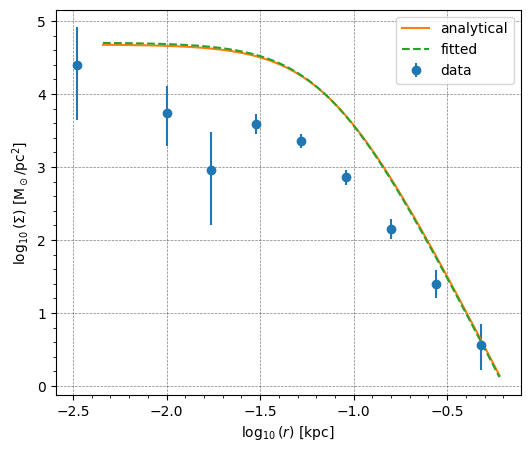

In [48]:
# fitted Plummer model
median = np.median(samples, axis=0)
plummer_fit = jgnn.jeans.density_profiles.Plummer(median[0], median[1])
print('Median posterior samples:')
print(f'L: {median[0]}')
print(f'r_star: {median[1]}')

# analytical Plummer model
plummer_ana = jgnn.jeans.density_profiles.Plummer(L=truths[0], r_star=truths[1])

# binned the data
binned_data = jgnn.jeans.utils.calc_Sigma(radius2d, return_bounds=True)
Sigma, Sigma_lo, Sigma_hi, logR_bins_lo, logR_bins_hi = binned_data


# Plot the light profile logR vs logL
fig, ax = plt.subplots(1, 1, figsize=(6, 5))

# plot the binned data as error bars
logR_bins_ce = 0.5 * (logR_bins_lo + logR_bins_hi)
yerr = (np.log10(Sigma) - np.log10(Sigma_lo), np.log10(Sigma_hi) - np.log10(Sigma))
ax.errorbar(logR_bins_ce, np.log10(Sigma), yerr=yerr, fmt='o', label='data')

# plot the fitted and analytical Plummer models
# get min and max radius for plotting
log_r_min = logR_bins_lo.min() * 0.9
log_r_max = logR_bins_hi.max() * 1.1
r = np.logspace(log_r_min, log_r_max, 1000)
ax.plot(np.log10(r), np.log10(plummer_ana(r)), label='analytical')
ax.plot(np.log10(r), np.log10(plummer_fit(r)), ls='--', label='fitted')

# set axis labels
ax.set_xlabel(r'$\log_{10}(r)$ [kpc]')
ax.set_ylabel(r'$\log_{10}(\Sigma)$ [M$_\odot$/pc$^2$]')

# minor ticks and major grid
ax.minorticks_on()
ax.grid(which='major', linestyle='--', alpha=0.5, linewidth='0.5', color='black')

# legend
ax.legend()

plt.show()

## Example 2: Fit the generalized NFW profile